Preparing Data And Preprocessing

d:\CC\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\CC\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\CC\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


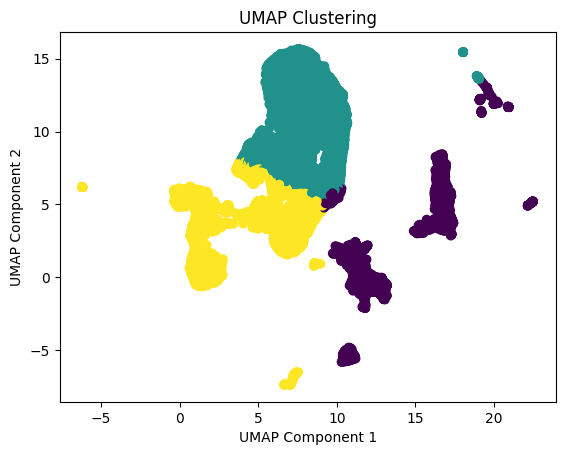

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import LocalOutlierFactor
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import umap.umap_ as umap

# ---- STEP 1: LOAD DATA ----
df = pd.read_excel('./data_files/Data_re.xlsx')  # Ensure the file exists

# ---- STEP 2: FEATURE SELECTION ----
cols_to_drop = ['object_id', 'specz_name', 'coord']  # Adjust based on dataset
features = [col for col in df.columns if col not in cols_to_drop + ['specz_redshift']]
df_selected = df[features]

# Remove low-variance features
var_thresh = VarianceThreshold(threshold=0.01)
df_selected = pd.DataFrame(var_thresh.fit_transform(df_selected), 
                           columns=np.array(features)[var_thresh.get_support()])

# ---- STEP 3: REMOVE OUTLIERS ----
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
outlier_scores = lof.fit_predict(df_selected)
df_clean = df_selected[outlier_scores == 1].copy()
df_clean['specz_redshift'] = df.loc[outlier_scores == 1, 'specz_redshift'].values

# ---- STEP 4: SCALING & TRANSFORMING ----
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean.drop(columns=['specz_redshift']))

# Apply Power Transformation (Yeo-Johnson for normalizing skewed data)
power_transformer = PowerTransformer(method='yeo-johnson')
df_transformed = power_transformer.fit_transform(df_scaled)

# ---- STEP 5: DIMENSIONALITY REDUCTION WITH UMAP ----
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(df_transformed)

# ---- STEP 6: OPTIONAL PCA FOR EXPLORATION ----
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df_transformed)

# ---- STEP 7: CLUSTERING ----
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(X_umap)

# ---- PLOT RESULTS ----
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df_clean['Cluster'], cmap='viridis')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Clustering')
plt.show()


Clustering (DBScan, K means and Gaussian Mixture Method)

Optimal eps for DBSCAN: 11.873
Optimal k for K-Means/GMM: 3


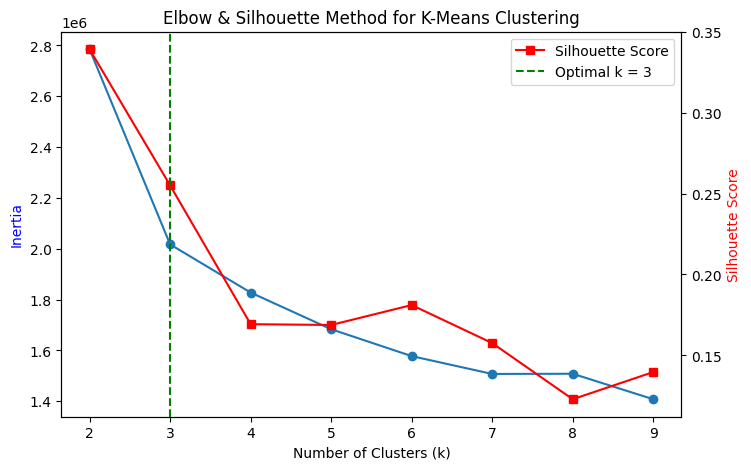

Silhouette Scores - KMeans: 0.255, GMM: 0.238, DBSCAN: 0.651


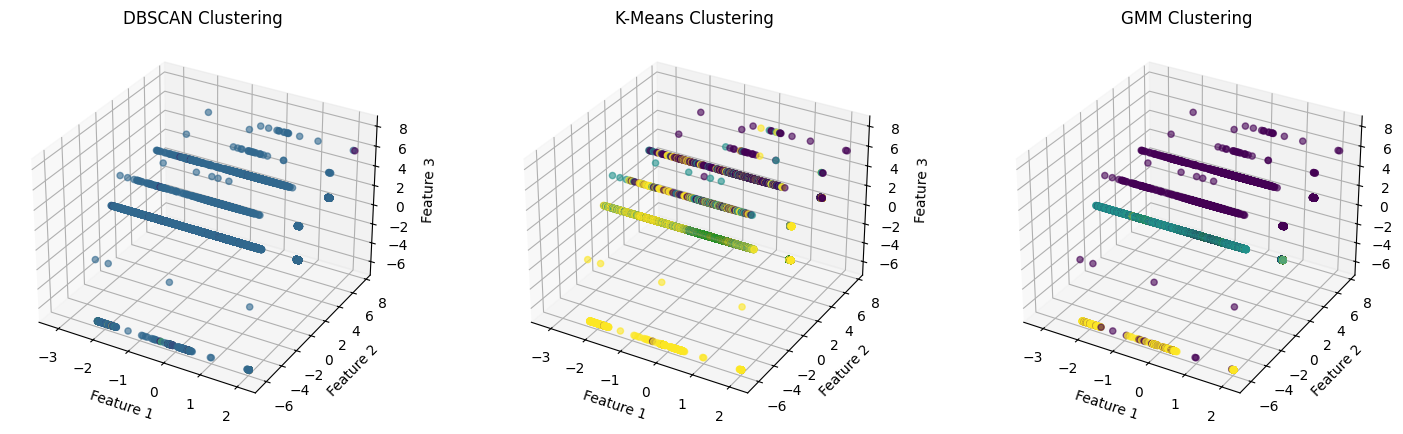

In [2]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score


# ---- STEP 6: DETERMINE OPTIMAL DBSCAN EPS ----
k = 5  # Typically, min_samples value
nearest_neighbors = NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(df_transformed)
distances, indices = nearest_neighbors.kneighbors(df_transformed)

# Sort distances to find the "knee" point
distances = np.sort(distances[:, -1])  # Last column gives the kth distance

# Use KneeLocator to find optimal epsilon
knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
optimal_eps = distances[knee_locator.elbow]
print(f"Optimal eps for DBSCAN: {optimal_eps:.3f}")

# ---- STEP 6A: APPLY DBSCAN CLUSTERING WITH OPTIMAL EPS ----
dbscan = DBSCAN(eps=optimal_eps, min_samples=k, metric='euclidean')
cluster_labels_dbscan = dbscan.fit_predict(df_transformed)
df_clean.loc[:, 'cluster_dbscan'] = cluster_labels_dbscan

# ---- STEP 6B: APPLY K-MEANS & GMM ----
# Determine the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(df_transformed)
    inertia.append(kmeans.inertia_)
    
    # Compute silhouette score
    score = silhouette_score(df_transformed, labels)
    silhouette_scores.append(score)

# Find the optimal k using the "knee" method
knee_locator = KneeLocator(k_range, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow
print(f"Optimal k for K-Means/GMM: {optimal_k}")

# Plot the Elbow Curve with silhouette scores
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(k_range, inertia, marker='o', label='Inertia')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='blue')

ax2 = ax1.twinx()
ax2.plot(k_range, silhouette_scores, marker='s', color='red', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='red')

plt.axvline(x=optimal_k, linestyle='--', color='green', label=f'Optimal k = {optimal_k}')
plt.title('Elbow & Silhouette Method for K-Means Clustering')
plt.legend()
plt.show()

# Apply K-Means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df_clean.loc[:, 'cluster_kmeans'] = kmeans.fit_predict(df_transformed)

# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df_clean.loc[:, 'cluster_gmm'] = gmm.fit_predict(df_transformed)

# ---- STEP 7: COMPUTE SILHOUETTE SCORES ----
silhouette_kmeans = silhouette_score(df_transformed, df_clean['cluster_kmeans'])
silhouette_gmm = silhouette_score(df_transformed, df_clean['cluster_gmm'])
silhouette_dbscan = silhouette_score(df_transformed[df_clean['cluster_dbscan'] != -1], 
                                     df_clean['cluster_dbscan'][df_clean['cluster_dbscan'] != -1])  # Ignore noise points (-1)

print(f"Silhouette Scores - KMeans: {silhouette_kmeans:.3f}, GMM: {silhouette_gmm:.3f}, DBSCAN: {silhouette_dbscan:.3f}")

# ---- STEP 8: VISUALIZE COMPARISON OF CLUSTERING METHODS (3D PLOTS) ----
fig = plt.figure(figsize=(18, 5))

# DBSCAN 3D Plot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(df_transformed[:, 0], df_transformed[:, 1], df_transformed[:, 2], c=cluster_labels_dbscan, cmap='viridis', alpha=0.6)
ax1.set_title("DBSCAN Clustering")
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")
ax1.set_zlabel("Feature 3")

# K-Means 3D Plot
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(df_transformed[:, 0], df_transformed[:, 1], df_transformed[:, 2], c=df_clean['cluster_kmeans'], cmap='viridis', alpha=0.6)
ax2.set_title("K-Means Clustering")
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")
ax2.set_zlabel("Feature 3")

# GMM 3D Plot
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(df_transformed[:, 0], df_transformed[:, 1], df_transformed[:, 2], c=df_clean['cluster_gmm'], cmap='viridis', alpha=0.6)
ax3.set_title("GMM Clustering")
ax3.set_xlabel("Feature 1")
ax3.set_ylabel("Feature 2")
ax3.set_zlabel("Feature 3")

plt.show()


Random Forest

In [3]:
# ---- STEP 8: RANDOM FOREST REGRESSION ----
# Train separate Random Forest models for each clustering method

results = {}

for cluster_type in ['cluster_dbscan', 'cluster_kmeans', 'cluster_gmm']:
    df_temp = pd.get_dummies(df_clean, columns=[cluster_type], prefix=[f'clust_{cluster_type}'])
    X = df_temp.drop(columns=['specz_redshift'])
    y = df_temp['specz_redshift']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[cluster_type] = {'MSE': mse, 'R2': r2, 'y_pred': y_pred}

# ---- STEP 10: COMPARE RESULTS ACROSS CLUSTERING METHODS ----
mse_dbscan, r2_dbscan = results['cluster_dbscan']['MSE'], results['cluster_dbscan']['R2']
mse_kmeans, r2_kmeans = results['cluster_kmeans']['MSE'], results['cluster_kmeans']['R2']
mse_gmm, r2_gmm = results['cluster_gmm']['MSE'], results['cluster_gmm']['R2']

print("Random Forest Regression Results:")
for cluster_type, metrics in results.items():
    print(f"{cluster_type.upper()} - MSE: {metrics['MSE']:.6f}, R2: {metrics['R2']:.6f}")
df_encoded = pd.get_dummies(df_clean, columns=['cluster_dbscan', 'cluster_kmeans', 'cluster_gmm'], prefix=['clust_dbscan', 'clust_kmeans', 'clust_gmm'])

# Define target and features
X = df_encoded.drop(columns=['specz_redshift'])
y = df_encoded['specz_redshift']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# ---- STEP 9: VISUALIZE REGRESSION RESULTS ----
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# DBSCAN
ax[0].scatter(y_test, results['cluster_dbscan']['y_pred'], alpha=0.6, color='blue')
ax[0].set_xlabel('Actual Redshift')
ax[0].set_ylabel('Predicted Redshift')
ax[0].set_title('Actual vs Predicted Redshift (DBSCAN)')
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# K-Means
ax[1].scatter(y_test, results['cluster_kmeans']['y_pred'], alpha=0.6, color='green')
ax[1].set_xlabel('Actual Redshift')
ax[1].set_ylabel('Predicted Redshift')
ax[1].set_title('Actual vs Predicted Redshift (K-Means)')
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# GMM
ax[2].scatter(y_test, results['cluster_gmm']['y_pred'], alpha=0.6, color='red')
ax[2].set_xlabel('Actual Redshift')
ax[2].set_ylabel('Predicted Redshift')
ax[2].set_title('Actual vs Predicted Redshift (GMM)')
ax[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()

# ---- STEP 10: COMPARE RESULTS ACROSS CLUSTERING METHODS ----
print("Random Forest Regression Results:")
print(f"DBSCAN - MSE: {mse_dbscan}, R2: {r2_dbscan}")
print(f"K-Means - MSE: {mse_kmeans}, R2: {r2_kmeans}")
print(f"GMM - MSE: {mse_gmm}, R2: {r2_gmm}")
print(f"Random Forest Regression Results:\nMean Squared Error: {mse}\nR2 Score: {r2}")


SVR and UMAP


In [ ]:
# Add-Ons for Photometric Redshift Estimation 
# Fixing UMAP Import Issue and Enhancing Preprocessing

# ---- STEP 11: Install and Import UMAP Properly ----
# Ensure proper UMAP installation: pip install umap-learn
from umap import UMAP  

umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap.fit_transform(df_transformed)

# ---- STEP 12: Add More Color Indices (u-g, g-r, r-i, i-z) ----
df_clean['y_g'] = df_clean['y_flux'] - df_clean['g_flux']
df_clean['g_r'] = df_clean['g_flux'] - df_clean['r_flux']
df_clean['r_i'] = df_clean['r_flux'] - df_clean['i_flux']
df_clean['i_z'] = df_clean['i_flux'] - df_clean['z_flux']

# ---- STEP 13: Additional Clustering (HDBSCAN) for SVR Comparison ----
try:
    from hdbscan import HDBSCAN
except ImportError:
    print("HDBSCAN not installed. Use: pip install hdbscan")
    raise

hdbscan = HDBSCAN(min_cluster_size=8)
df_clean['cluster_hdbscan'] = hdbscan.fit_predict(X_umap)

# ---- STEP 14: SVR Regression for Redshift Estimation ----
from sklearn.svm import SVR
svr_results = {}

for cluster_type in ['cluster_kmeans', 'cluster_gmm', 'cluster_hdbscan']:
    df_temp = pd.get_dummies(df_clean, columns=[cluster_type], prefix=[f'clust_{cluster_type}'])
    X = df_temp.drop(columns=['specz_redshift'])
    y = df_temp['specz_redshift']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    svr_results[cluster_type] = {'MSE': mse, 'R2': r2, 'y_pred': y_pred}

# ---- STEP 15: Plot SVR Results ----
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
titles = ['K-Means', 'GMM', 'HDBSCAN']
colors = ['purple', 'orange', 'cyan']

for i, cluster_type in enumerate(svr_results.keys()):
    ax[i].scatter(y_test, svr_results[cluster_type]['y_pred'], alpha=0.6, color=colors[i])
    ax[i].set_title(f'SVR Actual vs Predicted ({titles[i]})')
    ax[i].set_xlabel('Actual Redshift')
    ax[i].set_ylabel('Predicted Redshift')
    ax[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.tight_layout()
plt.show()

# ---- Print SVR Performance Metrics ----
print('SVR Regression Results:')
for cluster_type, metrics in svr_results.items():
    print(f"{cluster_type.upper()} - MSE: {metrics['MSE']:.6f}, R2: {metrics['R2']:.6f}")


d:\CC\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\CC\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyError: 'y'